<center>
<img src="https://supportvectors.ai/logo-poster-transparent.png" width="400px" style="opacity:0.7">
</center>

In [1]:
%run supportvectors-common.ipynb


<div style="color:#aaa;font-size:8pt">
<hr/>
&copy; SupportVectors. All rights reserved. <blockquote>This notebook is the intellectual property of SupportVectors, and part of its training material. 
Only the participants in SupportVectors workshops are allowed to study the notebooks for educational purposes currently, but is prohibited from copying or using it for any other purposes without written permission.

<b> These notebooks are chapters and sections from Asif Qamar's textbook that he is writing on Data Science. So we request you to not circulate the material to others.</b>
 </blockquote>
 <hr/>
</div>



# DCGAN trained with tree images

In [2]:
import torch

from torch import nn

import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import gc

from svlearn.config.configuration import ConfigurationMixin
from svlearn_gan.gan_trainer import load_checkpoint
from svlearn_gan.dcgan_models import TreeGenerator
from svlearn_gan.dcgan_datasets import load_tree_dataset


In [3]:
gc.collect()
torch.cuda.empty_cache()

The data and results directory

In [4]:
config = ConfigurationMixin().load_config()
current_task = 'tree-classification'

data_dir = config[current_task]['data']
results_dir = config[current_task]['results']

In [5]:
checkpoint_generator_file = f'{results_dir}/generator.pt'
checkpoint_discriminator_file = f'{results_dir}/discriminator.pt'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 16

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [6]:
# Global variables
# Number of channels in the training images. For color images this is 3
nc = config[current_task]['num_channels']

# Size of z latent vector (i.e. size of generator input)
nz = config[current_task]['nz']

# Size of feature maps in generator
ngf = config[current_task]['ngf']

# Size of feature maps in discriminator
ndf = config[current_task]['ndf']

# number of classes of training images
num_classes = config[current_task]['num_classes']

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")   
device = torch.device("mps") if torch.backends.mps.is_available() else device

In [7]:
# Create the dataset
dataset = load_tree_dataset()
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=workers)


In [8]:
# Create the generator and discriminator models
netG = TreeGenerator(nz, ngf, nc).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

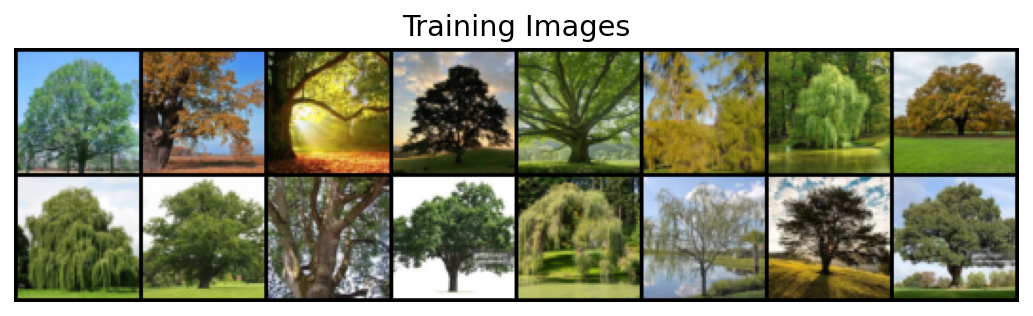

In [9]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(9,9))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

Import the already trained DCGAN

In [10]:
# load model weights from checkpoint if available else initialize weights randomly
load_checkpoint(netG , checkpoint_generator_file);


In [11]:
gen_checkpoint = torch.load(f"{results_dir}/generator.pt")
results = gen_checkpoint["results"]

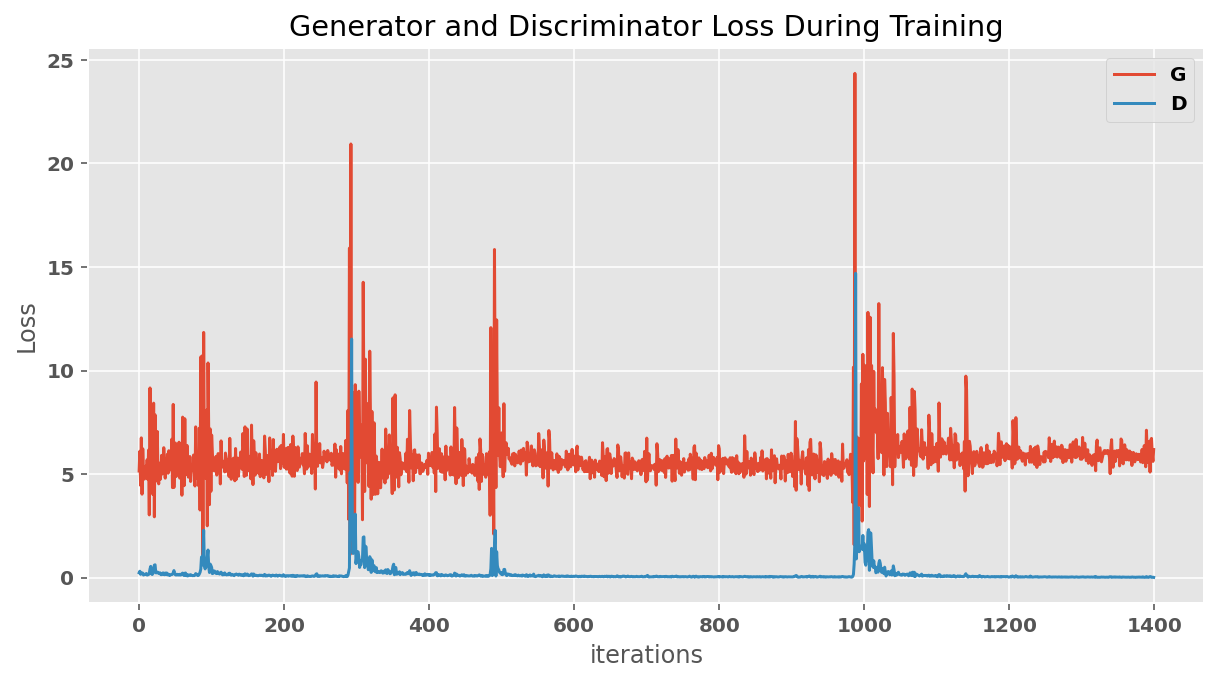

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(results["gen loss"],label="G")
plt.plot(results["dis loss"],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
netG.load_state_dict(gen_checkpoint["model_state_dict"])
netG.eval()

TreeGenerator(
  (first_layer): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (subsequent_layers): Sequential(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

Generate images using the DCGAN

In [14]:
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Create batch of latent vectors that we will use to visualize the generator
noise = torch.randn(16, nz, 1, 1, device=device)
with torch.no_grad():
    fake = netG(noise).cpu()
image_grid = vutils.make_grid(fake, padding=2, normalize=True)

Display the real and generated  images side by side

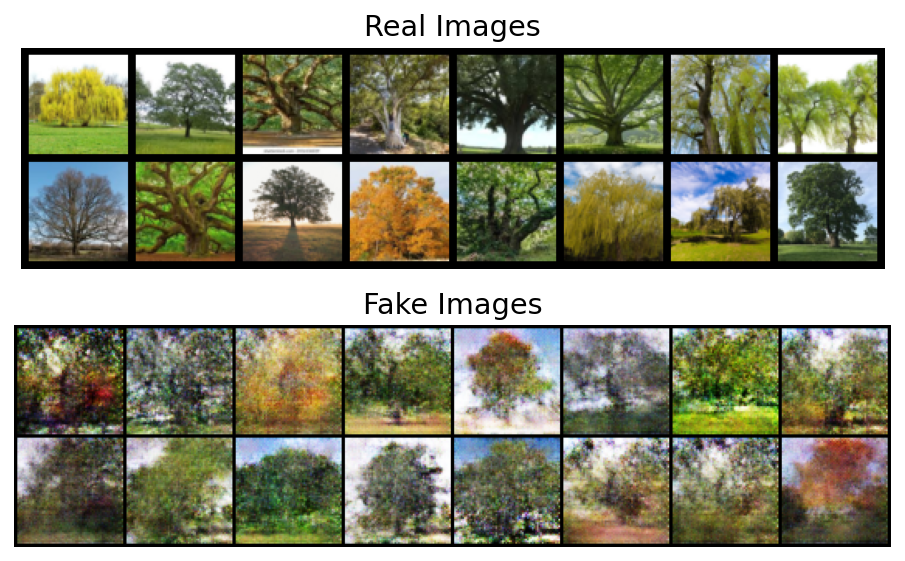

In [15]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

plt.figure(figsize=(8, 4))  # Adjust figure size as needed

# Top: Real Images
plt.subplot(2, 1, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

# Bottom: Fake Images
plt.subplot(2, 1, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(image_grid, (1, 2, 0)))

plt.tight_layout()
plt.show()